In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys

sys.path.append('../')

torch.set_printoptions(precision=10)

%load_ext autoreload
%autoreload 2

from transformer_lm.modeling_attention import SelfAttention, MultiHeadSelfAttention
from transformer_lm.test_values import SelfAttentionTestValues, MultiHeadAttentionTestValues

# Introduction to Transformer model

Till 2017-18, Recurrent neural network(RNN) were state of the art models for sequence modeling and transduction problems like language modeling and machine translation. In RNN, a sequence of hidden state $h_{t}$ are computed as a function of previous hidden state $h_{t-1}$ and input for position t. This process is sequencial and does not allow parallerlization. 

To overcome this problem, transformer based models were introduced which instead of using recurrent network employs only attention mechanism and fully connected layers.

Suggested reading - Attention Is All You Need https://arxiv.org/abs/1706.03762 

In this Homework we will implement the self attention and multi-head attention.


# Attention

There are generally two types of attention in a full Transformer model: self-attention and cross-attention. In the lecture we discussed the self-attention and this is what you will be implementing in this part of the homework.

As a warmup, you will first build a **SelfAttention** class which is an implementation of single head self attention mechanism. It will will help you better understand the idea behind attention and to jump-start the implementation of **MultiHeadAttention** class where mutliple heads are used to compute attention rather than single head.

**Note**: The purpose of SelfAttention class is not to be used in MultiAttention class but to provides a hands-on with a simple implementation of single head attention mechanism before moving onto multiple heads based attention. 

**This homework consists of two coding sections (5 tasks) and 4 inline questions**

1.  Complete **SelfAttention** class - An implementation of dot-product self-attention  
2.  Complete **MultiHeadAttention** class - An implementation of multi-head-attention  

# Coding Task 1. SelfAttention

Self attention is computed as follows

$$
Attention(Q,K,V) = softmax(\frac{QK^{T}}{\sqrt{d_{k}}})V
$$

where K, Q, and V are all projections of your input

Q = Query matrix
K = Key matrix  
V = Value matrix  
$d_{k}$ = Square root of the dimension of the key or query vector.

![image.png](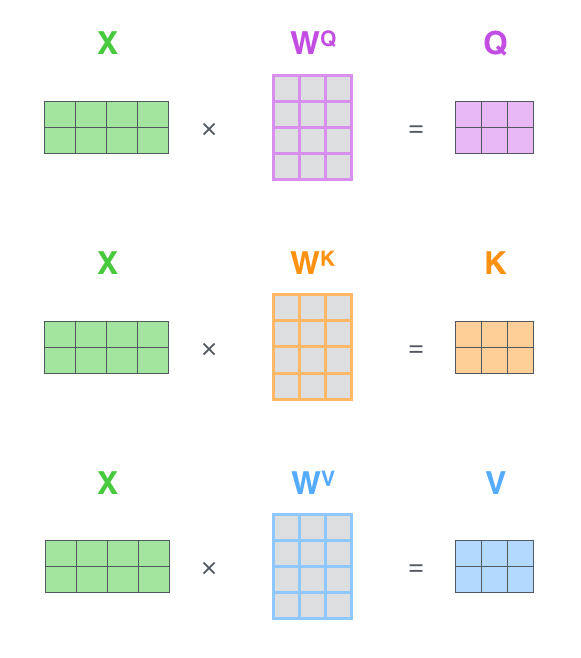
)
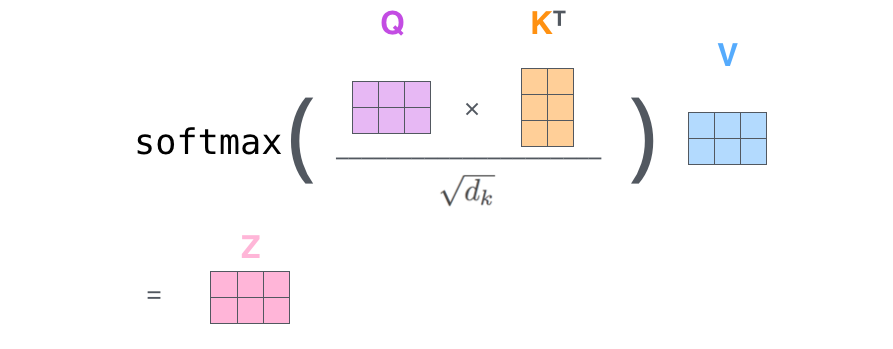

Image credit: Jay Alammar https://jalammar.github.io/illustrated-transformer

Z = Self Attention

Please read [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer) blogpost for more details.

Complete the code for the class `SelfAttention`. Read the docstring for every method you need to implement. It provides you with the information about the inputs of the function and the expected outputs. `bs` stands for batch size and `seq_len` is input sequence length.

You also need to write tensors shapes for every operation in a comment. For example, 

```python
x = x.transpose(0, 1)  # [batch, seq, h] -> [seq, batch, h]
```

Grades will be **deducted** if shapes of the tensors are not mentioned in your code.


*   Follow PEP-8. Violating pep-8 code formatting can lead to points deduction.
*   Remember to scale your scores.
*   Extra: can you implement .forward in 3 lines of pytorch code?


**Coding task 1 (4 points max):** Complete the SelfAttention class in `transformer_lm/modeling_attenton.py`.


## Test SelfAttention

After implementing the SelfAttention class run the following commands to call the class and run some tests.

In [2]:
model = SelfAttention(input_size=7, hidden=9)

model.k.weight.data = SelfAttentionTestValues.k_weight
model.q.weight.data = SelfAttentionTestValues.q_weight
model.v.weight.data = SelfAttentionTestValues.v_weight

model.k.bias.data = SelfAttentionTestValues.k_bias
model.q.bias.data = SelfAttentionTestValues.q_bias
model.v.bias.data = SelfAttentionTestValues.v_bias

output = model(SelfAttentionTestValues.x)

assert output.shape == (3, 5, 9), f"shape is incorrect, expected (3, 5, 9), got {output.shape}. Check your implementation."
if not torch.allclose(output, SelfAttentionTestValues.output, rtol=0.0001):
    print("Output shape is alright, but tensor values are incorrect.")
    print("Expected:")
    print(SelfAttentionTestValues.output)
    print("Got:")
    print(output)
    print("Please check your implementation.")
    assert False, "Output shape is alright, but tensor values are incorrect."

print("Tests passed!")


Tests passed!


### Inline questions:

Imagine you have two random matricies $K, Q \sim N(0, 1)$ of shape `[s, h]` and you compute $\operatorname{Softmax}(Q K^T)$.

**Q1:** How would softmax probabilities if we to increase $h$ to $2h$? Would they become more or less focused? Is is good for gradient flow?

> If you cannot show this mathematically, you can use pytorch and demonstrate it.

**NOTE:** There are tips below.


### Your answers here

**A1:**
With a higher h, the softmax probabilities would become more focused. This isn't great for gradient flow, because it will result in most of the probabilities being concentrated across a smaller amount of tokens, meaning that the network will be feeling quite confident in its predictions, and not learn or change much. 


**A2:**
This will help (especially when we are working with large vectors) to scale the dot product back down before feeding tit to the softmax. This is importance because if we have very large dot producs (as can happen with large vectors), this can result in having extremely small gradients, which, as stated above, are not great for learning.


### Tip 1

Look at how does the variance of k and q affects the variance of the scores.

Is the softmax of values with higher variance smoother that the softmax of values with lower variance?

### Tip 2

You will find a formula of variance of sum of independent random variables useful.

Variance of a product of independent random variables is also useful.

And the variance of a multiplication of a random varialbe and a scalar value.

### Tip 3

Look at the variance of a single element k_i and q_i. Remember that matrix multiplication $C = AB$ is just $C_{ik} = \sum_j A_{ij} B_{jk}$

# Coding task 2. Multi-head self-attention

Complete the **MultiheadSelfAttention(input_size, hidden_size, num_heads)** class in **layers.py** which accepts FloatTensor **[bs, seq_len, input_size]** and returns **FloatTensor[bs, seq_len, hidden_size]**. 'bs' stands for batch size and 'seq_len' is input sequence length. MultiHead attention is computed as below. 

**NOTE: Grades will be deducted if shapes of the tensors are not mentioned in your code**

Please read [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer) for more details.

$$MultiHead(Q,K,V) = Concat(head_{1}, head_{2}, ..., head_{h})W^{O} $$ 

where$$ head_{i} = Attention(QW_{i}^{Q}, KW_{i}^{K}, VW_{i}^{V})$$

$W_{i}^{Q}$ = Weight matrix for $i^{th}$ head which will be multiplied to $i^{th}$ Query matrix  
$W_{i}^{K}$ = Weight matrix for $i^{th}$ head which will be multiplied to $i^{th}$ Key matrix  
$W_{i}^{V}$ = Weight matrix for $i^{th}$ head which will be multiplied to $i^{th}$ Value matrix  
$W^{O}$ = Weight  matrix which projects concatination of individual head attention into the final attention.

*   It should include **casual masking** - casual masking is applied to the scores (query -key product) to ensure that model does not pay attention to the future or current input tokens.


Note :

-  Remember to mix the heads before the output.
-  First implement multi head attention without casual masking. By default, the arguments for casual masking is set to False (`casual=False`). 


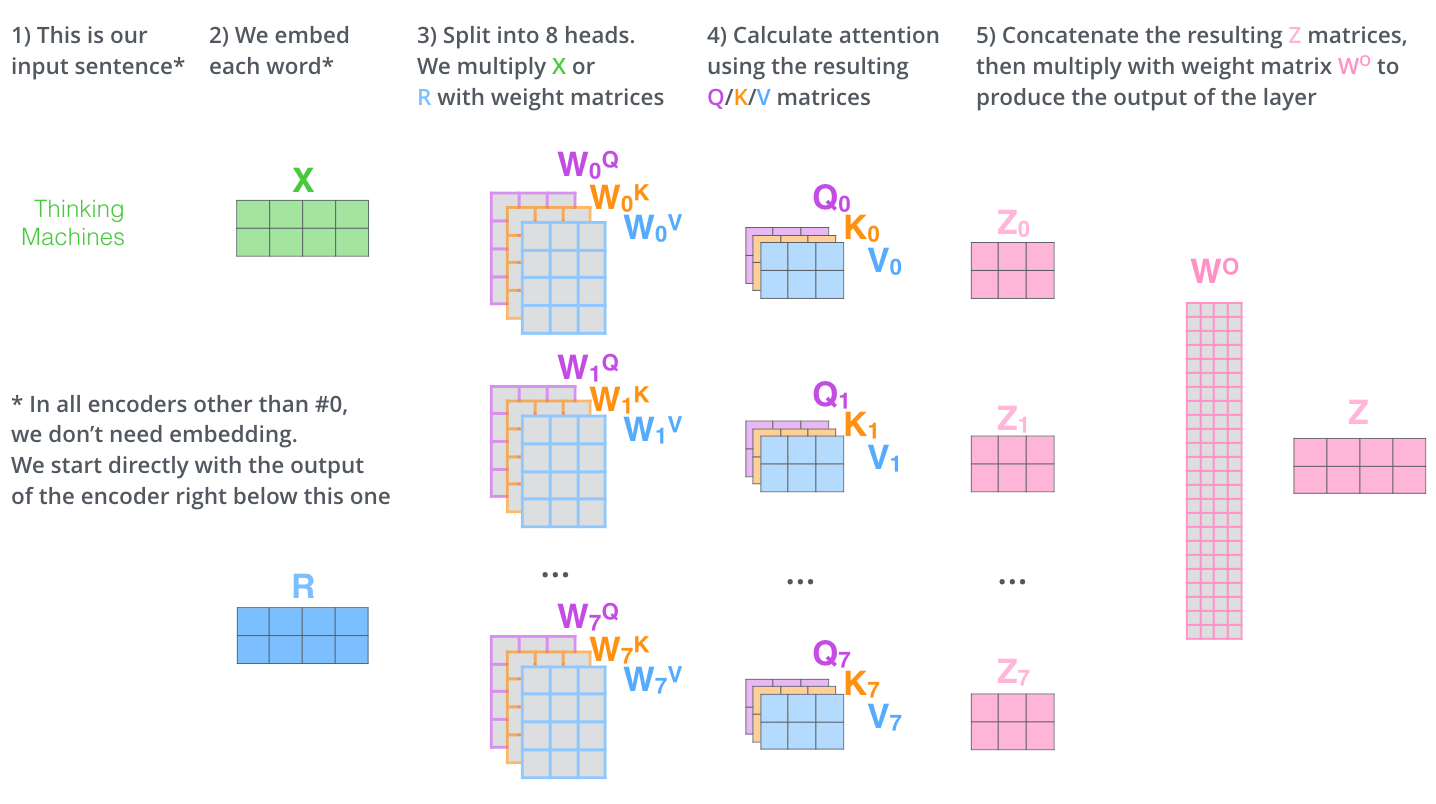

Image credit: Jay Alammar https://jalammar.github.io/illustrated-transformer

### Inline questions

**Q3:** Do we scale the scores the same way for multi-head and single-head attention?

**A3:**
Pretty much. Self attention is scaled  by a factor of sqrt(hidden), and multi attention is scaled by a  factor of sqrt(head_size), where head_size is hidden / num_heads, or the hidden size relative to that head. So yes in that both are being scaled by a factor of sqrt(hidden), but there is an extra step involved in calculating the hidden for num_heads

**Q4:** How many nonlinear operations do we have in self-attention? What about multi-head attention? Try to prove it.

**A4:**
There is one non-linear operation in each, unless you count the calculation of the scale, in which case there are two in each. The softmax activation function is nonlinear because of the exponentials, then the rest of the calculations are matrix operations (except the calculation of the scale), which are linear. 



## Test MultiHeadSelfAttention

After implementing the MultiHeadSelfAttention class run the following commands to call the class and run some tests.

In [3]:
model = MultiHeadSelfAttention(input_size=7, hidden=9, num_heads=3)

model.k.weight.data = MultiHeadAttentionTestValues.k_weight
model.q.weight.data = MultiHeadAttentionTestValues.q_weight
model.v.weight.data = MultiHeadAttentionTestValues.v_weight
model.mix.weight.data = MultiHeadAttentionTestValues.mix_weight

model.k.bias.data = MultiHeadAttentionTestValues.k_bias
model.q.bias.data = MultiHeadAttentionTestValues.q_bias
model.v.bias.data = MultiHeadAttentionTestValues.v_bias
model.mix.bias.data = MultiHeadAttentionTestValues.mix_bias

output = model(MultiHeadAttentionTestValues.x)

assert output.shape == (3, 5, 9), f"shape is incorrect, expected (3, 5, 9), got {output.shape}. Check your implementation."
if not torch.allclose(output, MultiHeadAttentionTestValues.output):
    print("Output shape is alright, but tensor values are incorrect.")
    print("Expected:")
    print(MultiHeadAttentionTestValues.output)
    print("Got:")
    print(output)
    print("Please check your implementation.")
    assert False, "Output shape is alright, but tensor values are incorrect. Look at the output above."
    
print("PASSED")


PASSED


## Test MultiHeadSelfAttention with causal masking

After implementing the MultiHeadSelfAttention class run the following commands to call the class and run some tests.

In [4]:
model = MultiHeadSelfAttention(input_size=7, hidden=9, num_heads=3, causal=True)

model.k.weight.data = MultiHeadAttentionTestValues.k_weight
model.q.weight.data = MultiHeadAttentionTestValues.q_weight
model.v.weight.data = MultiHeadAttentionTestValues.v_weight
model.mix.weight.data = MultiHeadAttentionTestValues.mix_weight

model.k.bias.data = MultiHeadAttentionTestValues.k_bias
model.q.bias.data = MultiHeadAttentionTestValues.q_bias
model.v.bias.data = MultiHeadAttentionTestValues.v_bias
model.mix.bias.data = MultiHeadAttentionTestValues.mix_bias

output = model(MultiHeadAttentionTestValues.x)

assert output.shape == (3, 5, 9), f"shape is incorrect, expected (3, 5, 9), got {output.shape}. Check your implementation."
if not torch.allclose(output, MultiHeadAttentionTestValues.output_causal, rtol=0.0001):
    print("Output shape is alright, but tensor values are incorrect.")
    print("Expected:")
    print(MultiHeadAttentionTestValues.output_causal)
    print("Got:")
    print(output)
    print("Please check your implementation.")
    assert False, "Output shape is alright, but tensor values are incorrect. Look at the output above."

print("Tests passed!")


Tests passed!


## Demostration to understand casual masking
### 1. No casual masking

In [5]:
model = MultiHeadSelfAttention(input_size=11, hidden=15, num_heads=3, causal=False)
x = torch.randn(3, 7, 11)
att, probs = model(x, return_attention=True)

In [6]:
probs.shape

torch.Size([9, 7, 7])

There are 3 input sequences. With first sequence of length 3, second of lenght 4 and third of length 7. Below three plots for probabilities for sequence 1, 2 and 3 no casual masking. Also note that the number of heads is 3.

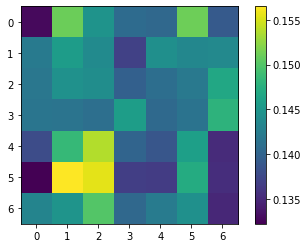

In [7]:
# sequence 1 with length 3
plt.imshow(torch.softmax(probs[0], dim=-1).detach().numpy())
plt.colorbar()

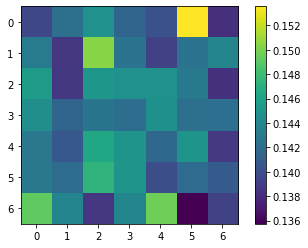

In [8]:
# sequence 2 with length 4
plt.imshow(torch.softmax(probs[3], dim=-1).detach().numpy())
plt.colorbar()

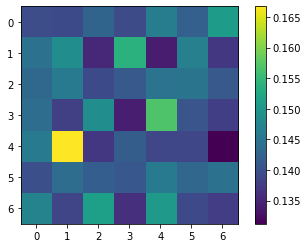

In [9]:
# sequence 3 with length 7
plt.imshow(torch.softmax(probs[6], dim=-1).detach().numpy())
plt.colorbar()

### 2. Causal masking

In [10]:
model = MultiHeadSelfAttention(input_size=11, hidden=15, num_heads=3, causal=True) # note the casual is set to True
x = torch.randn(3, 7, 11)

att, probs = model(x, return_attention=True)

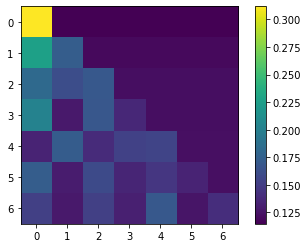

In [11]:
# check for first input sequence
# 0 + 3 heads
plt.imshow(torch.softmax(probs[0], dim=-1).detach().numpy())
plt.colorbar()

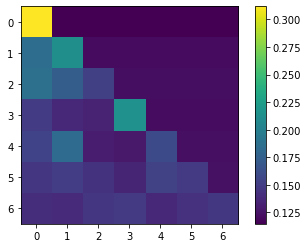

In [12]:
# check for second input sequence
# 0 + 4 heads
plt.imshow(torch.softmax(probs[3], dim=-1).detach().numpy())# check for second input sequence
plt.colorbar()

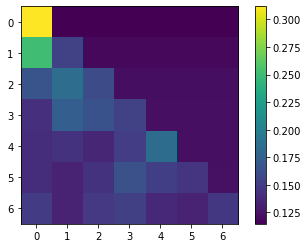

In [13]:
# check for third input sequence
# 0 + 7 heads
plt.imshow(torch.softmax(probs[6], dim=-1).detach().numpy())# check for third input sequence
plt.colorbar()

# Inline question 5:
Using above demostrations explain (with using one of the sequences as an example), what happens when 1) Causal masking is off 2) Causal masking is on

**A5:**

When causal masking is off, we can see that the model is able to consider every other word in the input sequence when making predictions. When it's on, we can see that the model is only able to consider words in one direction. This is represented visually with the dark square in the top diagonal half, where the dark squares represent probabilities of zero.  